<a href="https://colab.research.google.com/github/CoGian/Detection-of-toxic-comments-and-minimization-of-unintended-model-bias-using-neural-networks/blob/master/BiLSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import random
import pickle 
import gc
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/tools')
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification')
from tools_benchmark import  compute_bias_metrics_for_model, calculate_overall_auc,get_final_metric
from tools_load_data import get_datasets
from tools_evaluate_model import evaluate, plot_history_for_accuracy_and_loss

# TPU Configs

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.122.125.98:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.122.125.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.125.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
MODEL_NO = 2 
BATCH_SIZE = 512 
EPOCHS = 10

# Load Datasets

In [ ]:
 IDENTITY_COLUMNS  = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
  ] 

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/train_cleared.csv")
#train_df = train_df[:10000]
test_public_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_cleared.csv")
#test_public_df = test_public_df.loc[:, ['toxicity','comment_text']  + IDENTITY_COLUMNS ].dropna()[:1000]
test_private_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_cleared.csv")
#test_private_df = test_private_df.loc[:, ['toxicity', 'comment_text'] + IDENTITY_COLUMNS ].dropna()[:1000]

In [ ]:
# split 
train_df , val_df = train_test_split(train_df,test_size = 0.2 , random_state = 13 , shuffle = True)

In [ ]:
%%time 
train_dataset,validation_dataset, public_test_dataset, private_test_dataset , embedding_matrix = get_datasets(train_df, val_df, test_public_df, test_private_df)

n unknown words (glove):  1900
n known words (glove):  35560
n unknown words (crawl):  1949
n known words (crawl):  35560
CPU times: user 13.7 s, sys: 12.4 s, total: 26.1 s
Wall time: 1min 12s


# Training and evaluation of models 

In [ ]:
class CustomStopper(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             min_delta=0, patience=0, verbose=0, mode='auto', start_epoch = 2 , restore_best_weights = True): # add argument for starting epoch
        super(CustomStopper, self).__init__(monitor=monitor,patience=patience,min_delta=min_delta,mode=mode, restore_best_weights = restore_best_weights)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [ ]:
es = CustomStopper(start_epoch=2)

## Build model

In [ ]:
def create_BiLSTM(embedding_matrix, num_of_hidden_layers , lstm_units, dense_units):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim = embedding_matrix.shape[1],
                                 weights=[embedding_matrix], trainable=False)(words)
  x = tf.keras.layers.SpatialDropout1D(0.2)(x)
  if num_of_hidden_layers == 2 : 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,return_sequences=True))(x)
  elif num_of_hidden_layers == 3 : 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,return_sequences=True))(x)
  else:
    print("Wrong number of hidden layers")
    return
  
  
  
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)

  lstm_out = tf.keras.layers.concatenate([max_pool, avg_pool])

  # skip connections 
  x = tf.keras.layers.add([lstm_out,tf.keras.layers.Dense(dense_units,activation='relu')(lstm_out)]) 
  x = tf.keras.layers.add([x,tf.keras.layers.Dense(dense_units,activation='relu')(x)]) 
  
  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target' )(x)
  aux_result =  tf.keras.layers.Dense(6, activation='sigmoid' , name = 'aux')(x)
    
  model = tf.keras.Model(inputs=words, outputs=[result, aux_result])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

  return model

## Train and tune the model

In [ ]:
def train(number_of_hidden_lstm_layers, lstm_units, dense_units):
  histories = [] 
  public_predictions = [] 
  private_predictions = [] 
  MODEL_NAME = "BiLSTM" + str(number_of_hidden_lstm_layers)+"-"+str(lstm_units)
  print("\nBiLSTM" + str(number_of_hidden_lstm_layers)+"-"+str(lstm_units))
  PATH = 'BiLSTM/' + MODEL_NAME
      
  for i in range(MODEL_NO):
    
    with strategy.scope():
      # create model 
      BiLSTM = create_BiLSTM(embedding_matrix,number_of_hidden_lstm_layers, lstm_units, dense_units)
    BiLSTM.summary()
    n_steps = len(train_df) // BATCH_SIZE 
    history = BiLSTM.fit(x = train_dataset,validation_data=validation_dataset , callbacks=[es] , epochs = EPOCHS 
                          ,verbose = 1 , steps_per_epoch=n_steps)   
    histories.append(history)

    public_predictions.append(BiLSTM.predict(public_test_dataset, verbose=1 )[0].flatten())
    private_predictions.append(BiLSTM.predict(private_test_dataset, verbose=1 )[0].flatten())
    #save memmory 
    tf.tpu.experimental.initialize_tpu_system(tpu)

  y_public_pred = np.average(public_predictions, axis =0 )
  y_private_pred = np.average(private_predictions, axis= 0)
  # save its graph 
  tf.keras.utils.plot_model(BiLSTM, show_shapes= True ,show_layer_names=False, 
                  to_file='/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/BiLSTM/' + 
                  MODEL_NAME +'/BiLSTM.png')
  
  evaluate(y_public_pred,y_private_pred, test_public_df, test_private_df, PATH , MODEL_NAME)
  plot_history_for_accuracy_and_loss(histories, PATH)
  
  # delete to save memmory 
  del BiLSTM
  del y_public_pred
  del y_private_pred
  del histories 
  gc.collect()

### 2-LAYERS

#### BiLSTM2-64

In [ ]:
number_of_hidden_lstm_layers = 2 
lstm_units = 64
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)


BiLSTM2-64
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 600)    294721200   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 600)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 128)    340480      spatial_dropout1d[0][0]          
___________________________________________________________________________

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 1:40 - loss: 1.0401 - target_loss: 0.5030 - aux_loss: 0.5371 - target_accuracy: 0.7070 - aux_accuracy: 0.4795WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0613s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4772 - target_loss: 0.3247 - aux_loss: 0.1526 - target_accuracy: 0.6997 - aux_accuracy: 0.9272WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0335s). Check your callbacks.


2820/2820 [==============================] - 207s 74ms/step - loss: 0.4772 - target_loss: 0.3247 - aux_loss: 0.1526 - target_accuracy: 0.6997 - aux_accuracy: 0.9272 - val_loss: 0.4620 - val_target_loss: 0.3155 - val_aux_loss: 0.1465 - val_target_accuracy: 0.7002 - val_aux_accuracy: 0.9218
Epoch 2/10
1610/2820 [================>.............] - ETA: 1:18 - loss: 0.4622 - target_loss: 0.3158 - aux_loss: 0.1464 - target_accuracy: 0.6999 - aux_accuracy: 0.9263

#### BiLSTM2-128


BiLSTM2-128
Epoch 1/10
   2/2820 [..............................] - ETA: 1:54 - loss: 1.1866 - target_loss: 0.5722 - aux_loss: 0.6144 - target_accuracy: 0.6807 - aux_accuracy: 0.0264WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0708s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4745 - target_loss: 0.3234 - aux_loss: 0.1512 - target_accuracy: 0.6995 - aux_accuracy: 0.9220WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0347s). Check your callbacks.


2820/2820 [==============================] - 234s 83ms/step - loss: 0.4745 - target_loss: 0.3234 - aux_loss: 0.1512 - target_accuracy: 0.6995 - aux_accuracy: 0.9220 - val_loss: 0.4615 - val_target_loss: 0.3155 - val_aux_loss: 0.1460 - val_target_accuracy: 0.6994 - val_aux_accuracy: 0.9622
Epoch 2/10
2820/2820 [==============================] - 231s 82ms/step - loss: 0.4573 - target_loss: 0.3124 - aux_loss: 0.1449 - target_accuracy: 0.6999 - aux_accuracy: 0.9283 - val_loss: 0.4573 - val_target_loss: 0.3126 - val_aux_loss: 0.1447 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9636
Epoch 3/10
2820/2820 [==============================] - 231s 82ms/step - loss: 0.4525 - target_loss: 0.3091 - aux_loss: 0.1433 - target_accuracy: 0.7007 - aux_accuracy: 0.9351 - val_loss: 0.4569 - val_target_loss: 0.3123 - val_aux_loss: 0.1446 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9212
Epoch 4/10
2820/2820 [==============================] - 234s 83ms/step - loss: 0.4497 - target_loss: 0.3070 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0276s). Check your callbacks.


191/191 [==============================] - 5s 28ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.36.251.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.251.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 2:01 - loss: 1.1503 - target_loss: 0.5031 - aux_loss: 0.6472 - target_accuracy: 0.7178 - aux_accuracy: 0.0039WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0765s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4751 - target_loss: 0.3237 - aux_loss: 0.1514 - target_accuracy: 0.6996 - aux_accuracy: 0.9226WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0348s). Check your callbacks.


2820/2820 [==============================] - 234s 83ms/step - loss: 0.4751 - target_loss: 0.3237 - aux_loss: 0.1514 - target_accuracy: 0.6996 - aux_accuracy: 0.9226 - val_loss: 0.4597 - val_target_loss: 0.3140 - val_aux_loss: 0.1457 - val_target_accuracy: 0.7000 - val_aux_accuracy: 0.9500
Epoch 2/10
2820/2820 [==============================] - 231s 82ms/step - loss: 0.4576 - target_loss: 0.3127 - aux_loss: 0.1450 - target_accuracy: 0.6997 - aux_accuracy: 0.9303 - val_loss: 0.4574 - val_target_loss: 0.3126 - val_aux_loss: 0.1448 - val_target_accuracy: 0.6998 - val_aux_accuracy: 0.9019
Epoch 3/10
2820/2820 [==============================] - 232s 82ms/step - loss: 0.4523 - target_loss: 0.3090 - aux_loss: 0.1434 - target_accuracy: 0.7002 - aux_accuracy: 0.9370 - val_loss: 0.4561 - val_target_loss: 0.3118 - val_aux_loss: 0.1443 - val_target_accuracy: 0.7004 - val_aux_accuracy: 0.9480
Epoch 4/10
2820/2820 [==============================] - 237s 84ms/step - loss: 0.4492 - target_loss: 0.3068 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_predict_batch_end` time: 0.0293s). Check your callbacks.


191/191 [==============================] - 5s 28ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.36.251.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.251.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.952178
Accuracy on private test: 0.952353
Public AUC score : 0.933871
Private AUC score : 0.933306


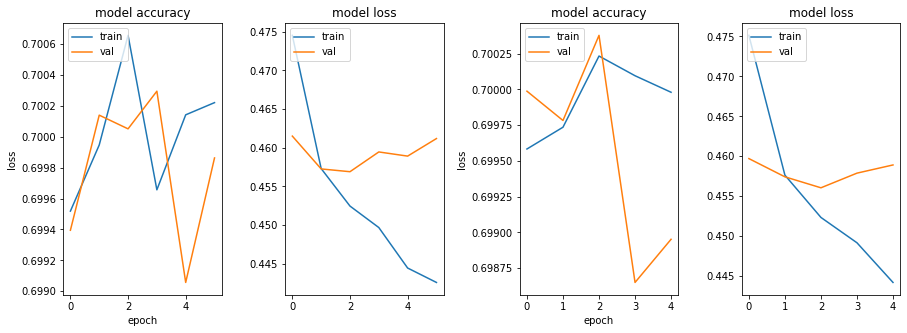

In [ ]:
number_of_hidden_lstm_layers = 2 
lstm_units = 128
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)

#### BiLSTM2-256

In [ ]:
number_of_hidden_lstm_layers = 2 
lstm_units = 256
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)

### 3-LAYERS

#### BiLSTM3-64


BiLSTM3-64
Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 1:58 - loss: 1.4546 - target_loss: 0.6539 - aux_loss: 0.8007 - target_accuracy: 0.4814 - aux_accuracy: 0.6416WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.0736s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4801 - target_loss: 0.3262 - aux_loss: 0.1539 - target_accuracy: 0.6991 - aux_accuracy: 0.9359WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0381s). Check your callbacks.


2820/2820 [==============================] - 246s 87ms/step - loss: 0.4801 - target_loss: 0.3262 - aux_loss: 0.1539 - target_accuracy: 0.6991 - aux_accuracy: 0.9359 - val_loss: 0.4619 - val_target_loss: 0.3156 - val_aux_loss: 0.1463 - val_target_accuracy: 0.6999 - val_aux_accuracy: 0.9309
Epoch 2/10
2820/2820 [==============================] - 245s 87ms/step - loss: 0.4600 - target_loss: 0.3142 - aux_loss: 0.1458 - target_accuracy: 0.7000 - aux_accuracy: 0.9261 - val_loss: 0.4583 - val_target_loss: 0.3133 - val_aux_loss: 0.1451 - val_target_accuracy: 0.6997 - val_aux_accuracy: 0.8916
Epoch 3/10
2820/2820 [==============================] - 245s 87ms/step - loss: 0.4556 - target_loss: 0.3112 - aux_loss: 0.1444 - target_accuracy: 0.6996 - aux_accuracy: 0.9337 - val_loss: 0.4571 - val_target_loss: 0.3124 - val_aux_loss: 0.1447 - val_target_accuracy: 0.6999 - val_aux_accuracy: 0.9442
Epoch 4/10
2820/2820 [==============================] - 248s 88ms/step - loss: 0.4537 - target_loss: 0.3098 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_predict_batch_end` time: 0.0291s). Check your callbacks.


191/191 [==============================] - 5s 28ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.10.104.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.104.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 2:08 - loss: 1.2007 - target_loss: 0.5939 - aux_loss: 0.6068 - target_accuracy: 0.3838 - aux_accuracy: 0.0215WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0025s vs `on_train_batch_end` time: 0.0776s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4803 - target_loss: 0.3268 - aux_loss: 0.1535 - target_accuracy: 0.6988 - aux_accuracy: 0.9288WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0383s). Check your callbacks.


2820/2820 [==============================] - 249s 88ms/step - loss: 0.4803 - target_loss: 0.3268 - aux_loss: 0.1535 - target_accuracy: 0.6988 - aux_accuracy: 0.9288 - val_loss: 0.4618 - val_target_loss: 0.3155 - val_aux_loss: 0.1463 - val_target_accuracy: 0.7003 - val_aux_accuracy: 0.9610
Epoch 2/10
2820/2820 [==============================] - 244s 87ms/step - loss: 0.4604 - target_loss: 0.3145 - aux_loss: 0.1459 - target_accuracy: 0.7000 - aux_accuracy: 0.9293 - val_loss: 0.4588 - val_target_loss: 0.3135 - val_aux_loss: 0.1453 - val_target_accuracy: 0.6996 - val_aux_accuracy: 0.9072
Epoch 3/10
2820/2820 [==============================] - 245s 87ms/step - loss: 0.4555 - target_loss: 0.3111 - aux_loss: 0.1443 - target_accuracy: 0.7002 - aux_accuracy: 0.9386 - val_loss: 0.4573 - val_target_loss: 0.3125 - val_aux_loss: 0.1448 - val_target_accuracy: 0.6996 - val_aux_accuracy: 0.9408
Epoch 4/10
2820/2820 [==============================] - 252s 89ms/step - loss: 0.4524 - target_loss: 0.3089 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_predict_batch_end` time: 0.0331s). Check your callbacks.


191/191 [==============================] - 6s 31ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.10.104.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.104.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.953761
Accuracy on private test: 0.953956
Public AUC score : 0.933292
Private AUC score : 0.933911


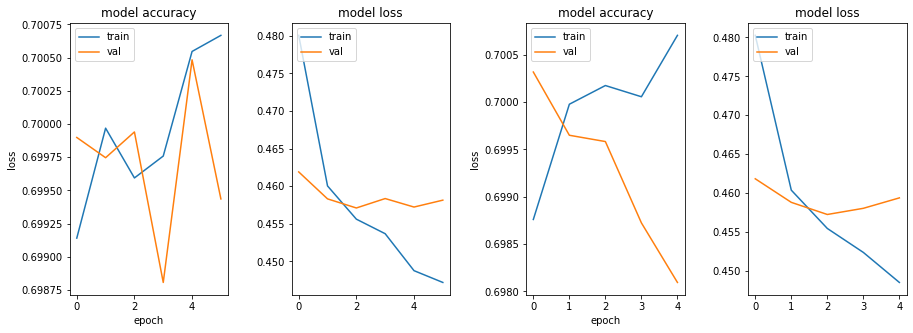

In [ ]:
number_of_hidden_lstm_layers = 3 
lstm_units = 64
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)

#### BiLSTM3-128

In [ ]:
number_of_hidden_lstm_layers = 3 
lstm_units = 128
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)


BiLSTM3-128
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 600)    294721200   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 600)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 256)    746496      spatial_dropout1d[0][0]          
__________________________________________________________________________

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 2:15 - loss: 1.2191 - target_loss: 0.5963 - aux_loss: 0.6228 - target_accuracy: 0.6660 - aux_accuracy: 0.2852WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0852s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4773 - target_loss: 0.3250 - aux_loss: 0.1523 - target_accuracy: 0.6993 - aux_accuracy: 0.9316WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0421s). Check your callbacks.


2820/2820 [==============================] - 282s 100ms/step - loss: 0.4773 - target_loss: 0.3250 - aux_loss: 0.1523 - target_accuracy: 0.6993 - aux_accuracy: 0.9316 - val_loss: 0.4624 - val_target_loss: 0.3159 - val_aux_loss: 0.1465 - val_target_accuracy: 0.7004 - val_aux_accuracy: 0.9020
Epoch 2/10
 713/2820 [======>.......................] - ETA: 3:06 - loss: 0.4579 - target_loss: 0.3126 - aux_loss: 0.1453 - target_accuracy: 0.7009 - aux_accuracy: 0.9266

KeyboardInterrupt: ignored

#### BiLSTM3-256


BiLSTM3-256
Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 3:13 - loss: 1.2704 - target_loss: 0.7243 - aux_loss: 0.5462 - target_accuracy: 0.6885 - aux_accuracy: 0.0742WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.1279s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4753 - target_loss: 0.3241 - aux_loss: 0.1512 - target_accuracy: 0.6987 - aux_accuracy: 0.9254WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_test_batch_end` time: 0.0503s). Check your callbacks.


2820/2820 [==============================] - 412s 146ms/step - loss: 0.4753 - target_loss: 0.3241 - aux_loss: 0.1512 - target_accuracy: 0.6987 - aux_accuracy: 0.9254 - val_loss: 0.4616 - val_target_loss: 0.3155 - val_aux_loss: 0.1461 - val_target_accuracy: 0.7003 - val_aux_accuracy: 0.9416
Epoch 2/10
2820/2820 [==============================] - 409s 145ms/step - loss: 0.4568 - target_loss: 0.3120 - aux_loss: 0.1448 - target_accuracy: 0.7004 - aux_accuracy: 0.9302 - val_loss: 0.4568 - val_target_loss: 0.3122 - val_aux_loss: 0.1446 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9398
Epoch 3/10
2820/2820 [==============================] - 411s 146ms/step - loss: 0.4492 - target_loss: 0.3068 - aux_loss: 0.1424 - target_accuracy: 0.7004 - aux_accuracy: 0.9388 - val_loss: 0.4562 - val_target_loss: 0.3119 - val_aux_loss: 0.1443 - val_target_accuracy: 0.7004 - val_aux_accuracy: 0.9343
Epoch 4/10
2820/2820 [==============================] - 415s 147ms/step - loss: 0.4468 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_predict_batch_end` time: 0.0396s). Check your callbacks.


191/191 [==============================] - 8s 43ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.97.43.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.43.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 3:19 - loss: 1.2622 - target_loss: 0.6869 - aux_loss: 0.5753 - target_accuracy: 0.3506 - aux_accuracy: 0.4834WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.1303s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4752 - target_loss: 0.3239 - aux_loss: 0.1513 - target_accuracy: 0.6991 - aux_accuracy: 0.9233WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_test_batch_end` time: 0.0528s). Check your callbacks.


2820/2820 [==============================] - 414s 147ms/step - loss: 0.4752 - target_loss: 0.3239 - aux_loss: 0.1513 - target_accuracy: 0.6991 - aux_accuracy: 0.9233 - val_loss: 0.4611 - val_target_loss: 0.3152 - val_aux_loss: 0.1459 - val_target_accuracy: 0.6987 - val_aux_accuracy: 0.9666
Epoch 2/10
2820/2820 [==============================] - 410s 146ms/step - loss: 0.4572 - target_loss: 0.3124 - aux_loss: 0.1448 - target_accuracy: 0.6998 - aux_accuracy: 0.9288 - val_loss: 0.4582 - val_target_loss: 0.3132 - val_aux_loss: 0.1451 - val_target_accuracy: 0.6996 - val_aux_accuracy: 0.9401
Epoch 3/10
2820/2820 [==============================] - 411s 146ms/step - loss: 0.4512 - target_loss: 0.3081 - aux_loss: 0.1431 - target_accuracy: 0.7002 - aux_accuracy: 0.9401 - val_loss: 0.4573 - val_target_loss: 0.3126 - val_aux_loss: 0.1446 - val_target_accuracy: 0.6989 - val_aux_accuracy: 0.9329
Epoch 4/10
2820/2820 [==============================] - 415s 147ms/step - loss: 0.4442 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_predict_batch_end` time: 0.0407s). Check your callbacks.


191/191 [==============================] - 8s 43ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.97.43.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.43.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.953309
Accuracy on private test: 0.953576
Public AUC score : 0.934038
Private AUC score : 0.933708


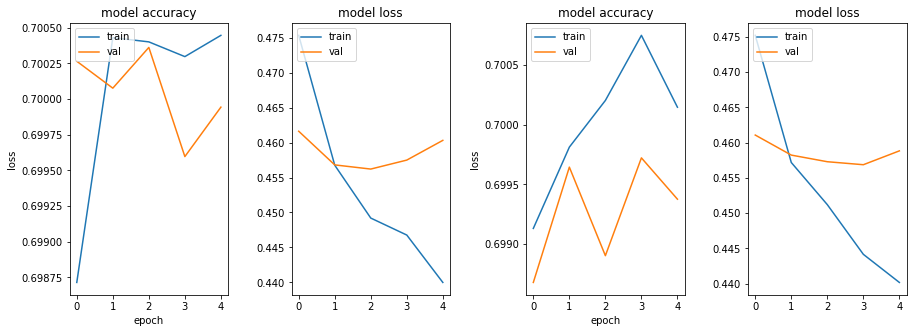

In [ ]:
number_of_hidden_lstm_layers = 3 
lstm_units = 256
dense_units = 4 * lstm_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_lstm_layers, lstm_units, dense_units)

## TextCNN

In [ ]:
def ConvNet2(embedding_matrix,num_aux_targets):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
  convs = []
  filter_sizes = [2,3,4,5,6]

  for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool =tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)
  
  l_merge = tf.concat(convs, axis=1)
  x = tf.keras.layers.Dropout(0.1)(l_merge)  
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target')(x)
  aux_result =  tf.keras.layers.Dense(num_aux_targets, activation='sigmoid', name = 'aux')(x)

  model = tf.keras.Model(inputs=words, outputs=[result, aux_result])
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  return model 

In [ ]:
model = ConvNet2(embedding_matrix, y_train_aux.shape[-1])
model.fit(train_dataset, epochs=EPOCHS , callbacks=[callback])